# Tomato disease classifier

This notebook is about building a tomato disease classifier that can be used to identify the possible disseases of your tomato using an image

In [1]:


# # downloaded the dataset:
# !curl -L -o /content/tomato-disease-multiple-sources.zip https://www.kaggle.com/api/v1/datasets/download/cookiefinder/tomato-disease-multiple-sources

# # Unzip the file
# !unzip /content/tomato-disease-multiple-sources.zip -d /content/tomato-disease-dataset

# # Remove the zip file
# !rm /content/tomato-disease-multiple-sources.zip

# import os

# # Change the working directory
# os.chdir('/content/tomato-disease-dataset')

# # Verify the change
# print(os.getcwd())


In [2]:
#importing required libraries for the job

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np



In [3]:
# Check if any GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If a CUDA device is available, use the first available GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Using the first available GPU at index 0
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [4]:
global IMAGE_SIZE, BATCH_SIZE, CHANNELS, NUM_CLASSES, EPOCH
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 80

In [5]:
#defining the path of the dateset
data_path = '/kaggle/input/tomato-disease-multiple-sources/train' #/content/tomato-disease-dataset/train

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(), # Convert to tensor
])

#Load dataset from directory
dataset = ImageFolder(root=data_path, transform=transform)

# Create DataLoader with batching
data_loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle=True,
                          num_workers=4,               # Number of workers for data loading
                          pin_memory=True,             # Use pinned memory for GPU transfer
                          prefetch_factor=2,            # Number of batches to prefetch per workers
                          persistent_workers=True      # Keep workers alive between epochs
                         )




In [6]:
CLASSES = dataset.classes
NUM_CLASSES = len(CLASSES)
print(NUM_CLASSES)

# View class names (subfolder names)
print("Class Names:")
for class_name in dataset.classes:
    print(class_name)

# View class-to-index mapping
print("\nClass-to-Index Mapping:")
for class_name, index in dataset.class_to_idx.items():
    print(f"{index}: {class_name}")

# View total number of samples
print("\nNumber of images:", len(dataset))

# View a single sample (image and label)
img1, label1 = dataset[0]  # Access the first sample
print("Image shape:", img1.shape)  # Shape of the image tensor
print("Label:", label1)  # Integer label corresponding to the class

11
Class Names:
Bacterial_spot
Early_blight
Late_blight
Leaf_Mold
Septoria_leaf_spot
Spider_mites Two-spotted_spider_mite
Target_Spot
Tomato_Yellow_Leaf_Curl_Virus
Tomato_mosaic_virus
healthy
powdery_mildew

Class-to-Index Mapping:
0: Bacterial_spot
1: Early_blight
2: Late_blight
3: Leaf_Mold
4: Septoria_leaf_spot
5: Spider_mites Two-spotted_spider_mite
6: Target_Spot
7: Tomato_Yellow_Leaf_Curl_Virus
8: Tomato_mosaic_virus
9: healthy
10: powdery_mildew

Number of images: 25851
Image shape: torch.Size([3, 256, 256])
Label: 0


In [7]:
num = len(data_loader)
print(num)

1616


In [8]:
print(num*32) #Matches the number of batches we have created and the number of images we have got


51712


In [9]:
for images, labels in data_loader:
    print(images.shape)
    print(labels.numpy())
    break

torch.Size([16, 3, 256, 256])
[5 4 9 5 0 7 2 4 9 3 3 8 3 5 4 7]


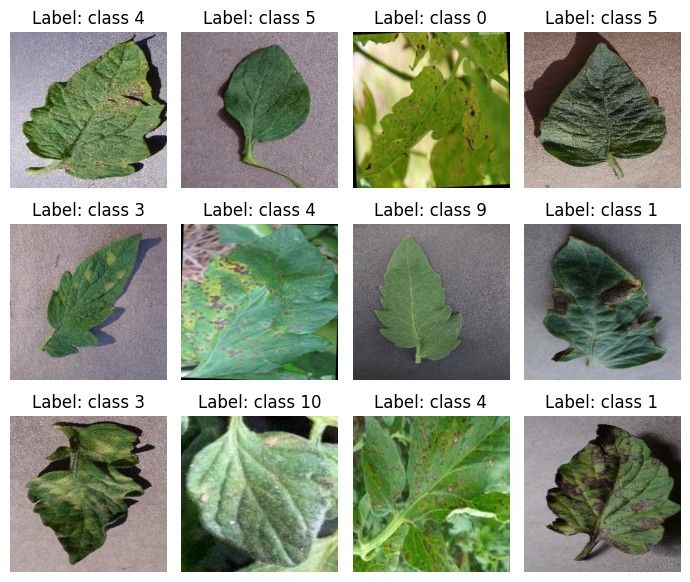

In [10]:
#for a singular image
for images, labels in data_loader:
  fig, axes = plt.subplots(3, 4, figsize=(7, 6)) 

  # Plot the first 12 images
  for i in range(12):
      row, col = divmod(i, 4)  
      ax = axes[row, col]
      ax.imshow(images[i].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
      ax.set_title(f"Label: class {labels[i].item()}")
      ax.axis('off')  # Turn off axes

  plt.tight_layout()
  plt.show()
  break

In [35]:
#defining the path of the valid and test dateset
valid_data_path = '/kaggle/input/tomato-disease-multiple-sources/valid' #'/content/tomato-disease-dataset/valid'

# Define the transformation
valid_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(),                       # Convert to tensor
])

# Load dataset from directory
valid_dataset = ImageFolder(root=valid_data_path, transform=valid_transform)

# Define the split sizes
valid_size = int(0.5 * len(valid_dataset))  # 50% for validation
test_size = len(valid_dataset) - valid_size  # Remaining for test

# Split the dataset
valid_subset, test_subset = random_split(valid_dataset, [valid_size, test_size])

# Create DataLoaders for validation and test sets
# Set a seed for reproducibility
torch.manual_seed(42)
valid_loader = DataLoader(valid_subset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )


# Set a seed for reproducibility
torch.manual_seed(42)
test_loader = DataLoader(test_subset,  batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )


In [12]:
# Check the size of SETS
print(f"Training set size: {len(data_loader)}")
print(f"Validation set size: {len(valid_loader)}")
print(f"Test set size: {len(test_loader)}")

Training set size: 1616
Validation set size: 209
Test set size: 209


torch.Size([3, 256, 256])
9


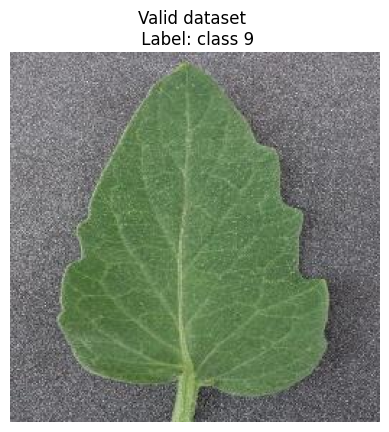

In [13]:
#Checking whether the datasets are fine
for images, labels in valid_loader:
    print(images[0].shape)
    print(labels[0].numpy())
    plt.imshow(images[0].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
    plt.title(f"Valid dataset \n Label: class {labels[0]}")
    plt.axis('off')
    plt.show()
    break

torch.Size([3, 256, 256])
7


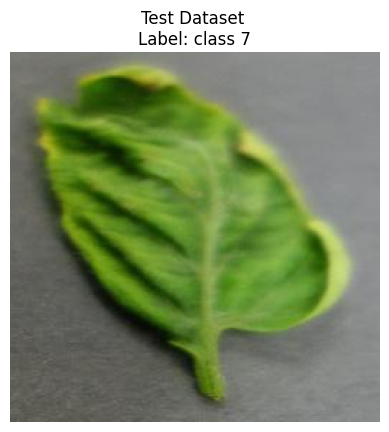

In [14]:
for images, labels in test_loader:
    print(images[0].shape)
    print(labels[0].numpy())
    plt.imshow(images[0].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
    plt.title(f"Test Dataset \nLabel: class {labels[0]}")
    plt.axis('off')
    plt.show()
    break

In [15]:
# Creating a neural network using the resnet-50 Archtecture
class RESNET(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):

        super(RESNET, self).__init__()
        self.backbone = getattr(models, 'resnet50')(pretrained=True)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
             nn.Linear(in_features, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, num_classes)
        )
        

    def forward(self, x):
        return self.backbone(x)

In [16]:
model = RESNET(
    num_classes= NUM_CLASSES, 
    freeze_backbone=True    # freeze pretrained weights initially
)

from torchsummary import summary

model.to(device)
summary(model, input_size=(3, 256, 256))  # (Channels, Height, Width)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR
from tqdm.notebook import tqdm
import gc
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Fine-tuning components initialization
def initialize_training_pretrained(model, num_epochs, train_loader, learning_rate=1e-4):
    """
    Initializes training components for fine-tuning.
    
    Args:
        model: PyTorch model.
        num_epochs: Number of epochs.
        train_loader: DataLoader for training data.
        learning_rate: Learning rate.

    Returns:
        device, criterion, optimizer, scheduler.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    params = [
        {'params': [p for n, p in model.named_parameters() if 'fc' in n or 'classifier' in n], 'lr': learning_rate},
        {'params': [p for n, p in model.named_parameters() if 'fc' not in n and 'classifier' not in n], 'lr': learning_rate / 10}
    ]

    optimizer = AdamW(params, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = OneCycleLR(optimizer, max_lr=[learning_rate, learning_rate / 10], epochs=num_epochs, steps_per_epoch=len(train_loader))

    return device, criterion, optimizer, scheduler

In [19]:
# Initialize training components
device, criterion, optimizer, scheduler = initialize_training_pretrained(
    model,
    num_epochs=EPOCH,
    train_loader=data_loader,
    learning_rate=1e-4
)

In [20]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                scheduler=None, early_stopping_patience=5):
    """
    Trains and validates a PyTorch model with Colab-optimized features.

    Args:
        model: The PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs to train
        device: Device to run the model on ('cpu' or 'cuda')
        scheduler: Optional learning rate scheduler
        early_stopping_patience: Number of epochs to wait before early stopping

    Returns:
        Trained model and dictionary containing training history
    """
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience)

    # Initialize history dictionary
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Get the start time
    start_time = datetime.now()

    print(f"Training started at {start_time.strftime('%H:%M:%S')}")
    print(f"Using device: {device}")

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            # Use tqdm for progress bar
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Clear gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate metrics
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == labels).sum().item()
                train_total += labels.size(0)

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')

            with torch.no_grad():
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)

                    val_pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{val_correct/val_total:.4f}'
                    })

            # Calculate epoch metrics
            avg_train_loss = train_loss / train_total
            avg_val_loss = val_loss / val_total
            train_accuracy = train_correct / train_total
            val_accuracy = val_correct / val_total

            # Update history
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_accuracy)
            history['val_acc'].append(val_accuracy)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

            # Learning rate scheduler step
            if scheduler is not None:
                scheduler.step()
                print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

            # Early stopping check
            if early_stopping(avg_val_loss, model):
                print("Early stopping triggered!")
                model.load_state_dict(early_stopping.best_model)
                break

            # Clear GPU memory
            torch.cuda.empty_cache()
            gc.collect()

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        if early_stopping.best_model is not None:
            print("Loading best model weights...")
            model.load_state_dict(early_stopping.best_model)

    # Calculate training time
    training_time = datetime.now() - start_time
    print(f"\nTraining completed in {training_time}")

    return model, history


In [22]:
# Train as before
trained_model, history = train_model(
    model=model,
    train_loader=data_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCH,
    device=device,
    scheduler=scheduler,
    early_stopping_patience=5
)

Training started at 07:13:44
Using device: cuda


Epoch 1/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 1/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 1/80 Summary:
Train Loss: 1.8432, Train Acc: 0.4775
Val Loss: 1.3839, Val Acc: 0.7379
Learning Rate: 0.000004


Epoch 2/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 2/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 2/80 Summary:
Train Loss: 1.3718, Train Acc: 0.6924
Val Loss: 1.1570, Val Acc: 0.7953
Learning Rate: 0.000004


Epoch 3/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 3/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 3/80 Summary:
Train Loss: 1.2146, Train Acc: 0.7492
Val Loss: 1.0563, Val Acc: 0.8199
Learning Rate: 0.000004


Epoch 4/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 4/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 4/80 Summary:
Train Loss: 1.1383, Train Acc: 0.7737
Val Loss: 1.0029, Val Acc: 0.8366
Learning Rate: 0.000004


Epoch 5/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 5/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 5/80 Summary:
Train Loss: 1.0878, Train Acc: 0.7942
Val Loss: 0.9735, Val Acc: 0.8420
Learning Rate: 0.000004


Epoch 6/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 6/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 6/80 Summary:
Train Loss: 1.0528, Train Acc: 0.8069
Val Loss: 0.9394, Val Acc: 0.8522
Learning Rate: 0.000004


Epoch 7/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 7/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 7/80 Summary:
Train Loss: 1.0277, Train Acc: 0.8125
Val Loss: 0.9280, Val Acc: 0.8573
Learning Rate: 0.000004


Epoch 8/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 8/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 8/80 Summary:
Train Loss: 1.0028, Train Acc: 0.8263
Val Loss: 0.9157, Val Acc: 0.8618
Learning Rate: 0.000004


Epoch 9/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 9/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 9/80 Summary:
Train Loss: 0.9854, Train Acc: 0.8300
Val Loss: 0.8964, Val Acc: 0.8701
Learning Rate: 0.000004


Epoch 10/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 10/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 10/80 Summary:
Train Loss: 0.9711, Train Acc: 0.8368
Val Loss: 0.8912, Val Acc: 0.8680
Learning Rate: 0.000004


Epoch 11/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 11/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 11/80 Summary:
Train Loss: 0.9616, Train Acc: 0.8414
Val Loss: 0.8751, Val Acc: 0.8812
Learning Rate: 0.000004


Epoch 12/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 12/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 12/80 Summary:
Train Loss: 0.9451, Train Acc: 0.8506
Val Loss: 0.8555, Val Acc: 0.8896
Learning Rate: 0.000004


Epoch 13/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 13/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 13/80 Summary:
Train Loss: 0.9380, Train Acc: 0.8512
Val Loss: 0.8629, Val Acc: 0.8887
Learning Rate: 0.000004


Epoch 14/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 14/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 14/80 Summary:
Train Loss: 0.9233, Train Acc: 0.8587
Val Loss: 0.8520, Val Acc: 0.8887
Learning Rate: 0.000004


Epoch 15/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 15/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 15/80 Summary:
Train Loss: 0.9196, Train Acc: 0.8589
Val Loss: 0.8447, Val Acc: 0.8947
Learning Rate: 0.000004


Epoch 16/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 16/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 16/80 Summary:
Train Loss: 0.9062, Train Acc: 0.8686
Val Loss: 0.8315, Val Acc: 0.9010
Learning Rate: 0.000004


Epoch 17/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 17/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 17/80 Summary:
Train Loss: 0.8987, Train Acc: 0.8719
Val Loss: 0.8313, Val Acc: 0.8995
Learning Rate: 0.000004


Epoch 18/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 18/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 18/80 Summary:
Train Loss: 0.8946, Train Acc: 0.8713
Val Loss: 0.8288, Val Acc: 0.8965
Learning Rate: 0.000004


Epoch 19/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 19/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 19/80 Summary:
Train Loss: 0.8842, Train Acc: 0.8768
Val Loss: 0.8153, Val Acc: 0.9034
Learning Rate: 0.000004


Epoch 20/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 20/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 20/80 Summary:
Train Loss: 0.8760, Train Acc: 0.8816
Val Loss: 0.8093, Val Acc: 0.9042
Learning Rate: 0.000004


Epoch 21/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 21/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 21/80 Summary:
Train Loss: 0.8730, Train Acc: 0.8828
Val Loss: 0.8080, Val Acc: 0.9051
Learning Rate: 0.000004


Epoch 22/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 22/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 22/80 Summary:
Train Loss: 0.8704, Train Acc: 0.8838
Val Loss: 0.8014, Val Acc: 0.9105
Learning Rate: 0.000004


Epoch 23/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 23/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 23/80 Summary:
Train Loss: 0.8625, Train Acc: 0.8870
Val Loss: 0.7962, Val Acc: 0.9147
Learning Rate: 0.000004


Epoch 24/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 24/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 24/80 Summary:
Train Loss: 0.8600, Train Acc: 0.8876
Val Loss: 0.8012, Val Acc: 0.9084
Learning Rate: 0.000004


Epoch 25/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 25/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 25/80 Summary:
Train Loss: 0.8500, Train Acc: 0.8928
Val Loss: 0.8017, Val Acc: 0.9084
Learning Rate: 0.000004


Epoch 26/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 26/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 26/80 Summary:
Train Loss: 0.8457, Train Acc: 0.8989
Val Loss: 0.7877, Val Acc: 0.9162
Learning Rate: 0.000004


Epoch 27/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 27/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 27/80 Summary:
Train Loss: 0.8427, Train Acc: 0.8964
Val Loss: 0.7858, Val Acc: 0.9165
Learning Rate: 0.000004


Epoch 28/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 28/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 28/80 Summary:
Train Loss: 0.8376, Train Acc: 0.8979
Val Loss: 0.7755, Val Acc: 0.9210
Learning Rate: 0.000004


Epoch 29/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 29/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 29/80 Summary:
Train Loss: 0.8333, Train Acc: 0.9015
Val Loss: 0.7868, Val Acc: 0.9141
Learning Rate: 0.000004


Epoch 30/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 30/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 30/80 Summary:
Train Loss: 0.8257, Train Acc: 0.9072
Val Loss: 0.7769, Val Acc: 0.9207
Learning Rate: 0.000004


Epoch 31/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 31/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 31/80 Summary:
Train Loss: 0.8236, Train Acc: 0.9053
Val Loss: 0.7742, Val Acc: 0.9213
Learning Rate: 0.000004


Epoch 32/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 32/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 32/80 Summary:
Train Loss: 0.8219, Train Acc: 0.9065
Val Loss: 0.7774, Val Acc: 0.9219
Learning Rate: 0.000004


Epoch 33/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 33/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 33/80 Summary:
Train Loss: 0.8148, Train Acc: 0.9107
Val Loss: 0.7799, Val Acc: 0.9177
Learning Rate: 0.000004


Epoch 34/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 34/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 34/80 Summary:
Train Loss: 0.8119, Train Acc: 0.9116
Val Loss: 0.7660, Val Acc: 0.9237
Learning Rate: 0.000004


Epoch 35/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 35/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 35/80 Summary:
Train Loss: 0.8090, Train Acc: 0.9131
Val Loss: 0.7692, Val Acc: 0.9198
Learning Rate: 0.000004


Epoch 36/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 36/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 36/80 Summary:
Train Loss: 0.8074, Train Acc: 0.9139
Val Loss: 0.7593, Val Acc: 0.9261
Learning Rate: 0.000004


Epoch 37/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 37/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 37/80 Summary:
Train Loss: 0.8034, Train Acc: 0.9158
Val Loss: 0.7551, Val Acc: 0.9303
Learning Rate: 0.000004


Epoch 38/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 38/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 38/80 Summary:
Train Loss: 0.7965, Train Acc: 0.9195
Val Loss: 0.7532, Val Acc: 0.9300
Learning Rate: 0.000004


Epoch 39/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 39/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 39/80 Summary:
Train Loss: 0.7982, Train Acc: 0.9182
Val Loss: 0.7556, Val Acc: 0.9282
Learning Rate: 0.000004


Epoch 40/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 40/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 40/80 Summary:
Train Loss: 0.7937, Train Acc: 0.9209
Val Loss: 0.7539, Val Acc: 0.9309
Learning Rate: 0.000004


Epoch 41/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 41/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 41/80 Summary:
Train Loss: 0.7885, Train Acc: 0.9236
Val Loss: 0.7448, Val Acc: 0.9357
Learning Rate: 0.000004


Epoch 42/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 42/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 42/80 Summary:
Train Loss: 0.7885, Train Acc: 0.9244
Val Loss: 0.7488, Val Acc: 0.9327
Learning Rate: 0.000004


Epoch 43/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 43/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 43/80 Summary:
Train Loss: 0.7841, Train Acc: 0.9258
Val Loss: 0.7437, Val Acc: 0.9387
Learning Rate: 0.000004


Epoch 44/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 44/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 44/80 Summary:
Train Loss: 0.7842, Train Acc: 0.9246
Val Loss: 0.7462, Val Acc: 0.9324
Learning Rate: 0.000004


Epoch 45/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 45/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 45/80 Summary:
Train Loss: 0.7804, Train Acc: 0.9281
Val Loss: 0.7383, Val Acc: 0.9366
Learning Rate: 0.000004


Epoch 46/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 46/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 46/80 Summary:
Train Loss: 0.7775, Train Acc: 0.9292
Val Loss: 0.7390, Val Acc: 0.9369
Learning Rate: 0.000004


Epoch 47/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 47/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 47/80 Summary:
Train Loss: 0.7744, Train Acc: 0.9294
Val Loss: 0.7483, Val Acc: 0.9336
Learning Rate: 0.000004


Epoch 48/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 48/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 48/80 Summary:
Train Loss: 0.7689, Train Acc: 0.9309
Val Loss: 0.7338, Val Acc: 0.9375
Learning Rate: 0.000004


Epoch 49/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 49/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 49/80 Summary:
Train Loss: 0.7706, Train Acc: 0.9336
Val Loss: 0.7297, Val Acc: 0.9464
Learning Rate: 0.000004


Epoch 50/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 50/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 50/80 Summary:
Train Loss: 0.7660, Train Acc: 0.9312
Val Loss: 0.7283, Val Acc: 0.9446
Learning Rate: 0.000004


Epoch 51/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 51/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 51/80 Summary:
Train Loss: 0.7632, Train Acc: 0.9355
Val Loss: 0.7303, Val Acc: 0.9437
Learning Rate: 0.000004


Epoch 52/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 52/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 52/80 Summary:
Train Loss: 0.7611, Train Acc: 0.9378
Val Loss: 0.7281, Val Acc: 0.9414
Learning Rate: 0.000004


Epoch 53/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 53/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 53/80 Summary:
Train Loss: 0.7604, Train Acc: 0.9383
Val Loss: 0.7340, Val Acc: 0.9384
Learning Rate: 0.000004


Epoch 54/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 54/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 54/80 Summary:
Train Loss: 0.7567, Train Acc: 0.9393
Val Loss: 0.7266, Val Acc: 0.9428
Learning Rate: 0.000004


Epoch 55/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 55/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 55/80 Summary:
Train Loss: 0.7533, Train Acc: 0.9408
Val Loss: 0.7214, Val Acc: 0.9482
Learning Rate: 0.000004


Epoch 56/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 56/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 56/80 Summary:
Train Loss: 0.7545, Train Acc: 0.9422
Val Loss: 0.7279, Val Acc: 0.9425
Learning Rate: 0.000004


Epoch 57/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 57/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 57/80 Summary:
Train Loss: 0.7522, Train Acc: 0.9404
Val Loss: 0.7173, Val Acc: 0.9500
Learning Rate: 0.000004


Epoch 58/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 58/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 58/80 Summary:
Train Loss: 0.7518, Train Acc: 0.9411
Val Loss: 0.7214, Val Acc: 0.9479
Learning Rate: 0.000004


Epoch 59/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 59/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 59/80 Summary:
Train Loss: 0.7496, Train Acc: 0.9419
Val Loss: 0.7215, Val Acc: 0.9476
Learning Rate: 0.000004


Epoch 60/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 60/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 60/80 Summary:
Train Loss: 0.7468, Train Acc: 0.9435
Val Loss: 0.7183, Val Acc: 0.9467
Learning Rate: 0.000004


Epoch 61/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 61/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 61/80 Summary:
Train Loss: 0.7452, Train Acc: 0.9455
Val Loss: 0.7096, Val Acc: 0.9566
Learning Rate: 0.000004


Epoch 62/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 62/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 62/80 Summary:
Train Loss: 0.7420, Train Acc: 0.9466
Val Loss: 0.7187, Val Acc: 0.9479
Learning Rate: 0.000004


Epoch 63/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 63/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 63/80 Summary:
Train Loss: 0.7403, Train Acc: 0.9463
Val Loss: 0.7254, Val Acc: 0.9420
Learning Rate: 0.000004


Epoch 64/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 64/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 64/80 Summary:
Train Loss: 0.7381, Train Acc: 0.9478
Val Loss: 0.7147, Val Acc: 0.9503
Learning Rate: 0.000004


Epoch 65/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 65/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 65/80 Summary:
Train Loss: 0.7401, Train Acc: 0.9467
Val Loss: 0.7182, Val Acc: 0.9458
Learning Rate: 0.000004


Epoch 66/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 66/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 66/80 Summary:
Train Loss: 0.7376, Train Acc: 0.9473
Val Loss: 0.7126, Val Acc: 0.9503
Learning Rate: 0.000004
Early stopping triggered!

Training completed in 1:16:26.642513


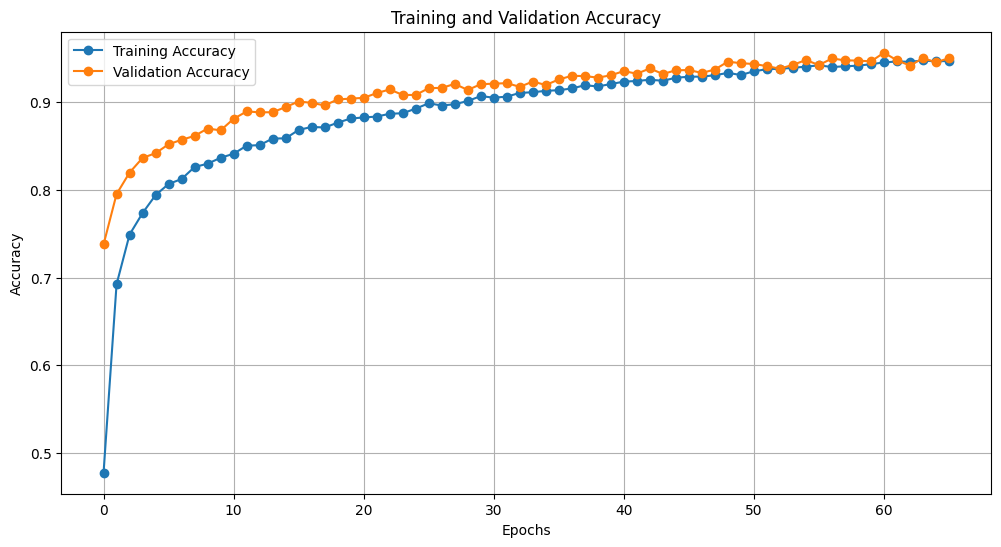

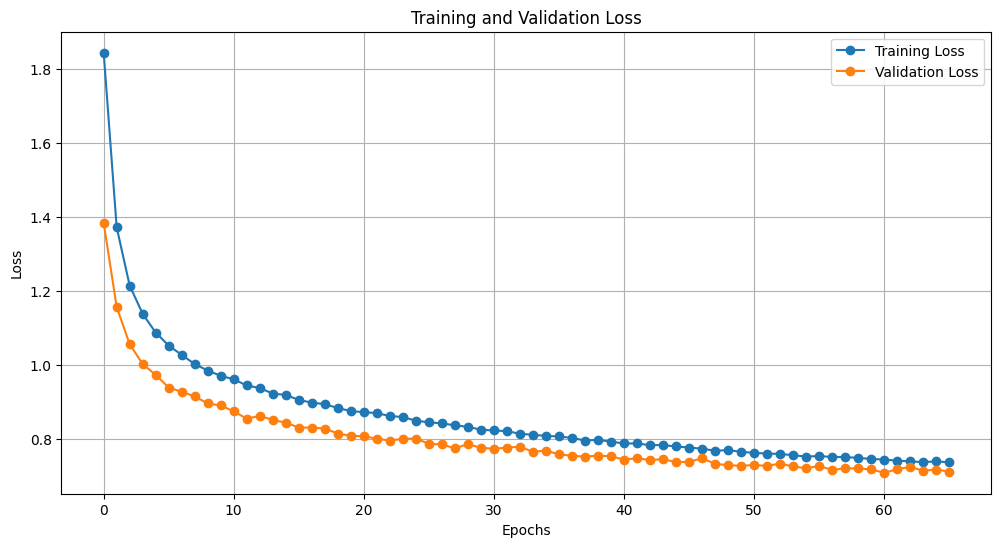

In [23]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history["train_acc"], label="Training Accuracy", marker="o")
plt.plot(history["val_acc"], label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history["train_loss"], label="Training Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [26]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates the accuracy of the model on the given DataLoader.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to evaluate.
        device: Device to run the model on ('cpu' or 'cuda').

    Returns:
        accuracy: Accuracy of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Predictions
            predicted = outputs.argmax(dim=1)

            # Count correctly classified samples
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = correct / total
    return accuracy




In [37]:
# Evaluate the model
true_accuracy = evaluate_model(trained_model, test_loader, device)
print(f"Test Accuracy: {true_accuracy:.4f}")


Test Accuracy: 0.9623


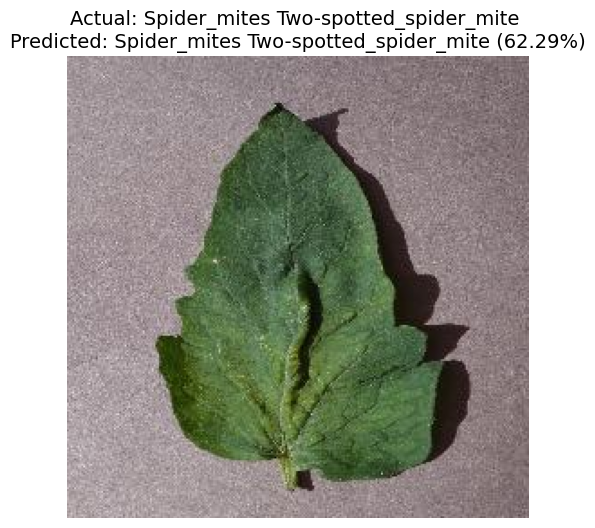

In [30]:
def visualize_prediction(model, data, device, class_names):
    """
    Displays a test image along with its actual and predicted class probabilities.

    Args:
        model: Trained PyTorch model.
        data: A single (image, label) tuple from the dataset or DataLoader.
        device: The device to run the model on ('cpu' or 'cuda').
        class_names: List of class names corresponding to the labels.
    """
    model.eval()  # Set the model to evaluation mode

    # Unpack the image and label
    img, label = data
    img, label = img.to(device), label.to(device)

    # Add batch dimension to the image if needed
    img_batch = img.unsqueeze(0)

    # Predict the class of the image
    with torch.no_grad():
        outputs = model(img_batch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Convert the image tensor to a NumPy array for visualization
    img_np = img.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
    img_np = np.clip(img_np, 0, 1)  # Ensure pixel values are in range [0, 1]

    # Get actual and predicted class names and probabilities
    actual_class = class_names[label.item()]
    predicted_class = class_names[predicted.item()]
    predicted_prob = probabilities[0, predicted.item()].item() * 100
    
    

    # Plot the image with predicted and actual class
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title(f"Actual: {actual_class} \nPredicted: {predicted_class} ({predicted_prob:.2f}%)", fontsize=14)
    plt.axis('off')
    plt.show()

# Visualizing a single image from the test_loader
for img, label in test_loader:  # Get one batch of data
    visualize_prediction(trained_model, (img[0], label[0]), device, CLASSES)  # Visualize the first image
    break


In [31]:
#Downloading the model's state_dict
torch.save(trained_model.state_dict(), "/kaggle/working/trained_model_v1.pth")

#Also downloading the full model just in case
torch.save(trained_model, "/kaggle/working/trained_model_complete_v1.pth")
